### BMI WorkFlow

- This project implements a workflow for calculating and classifying Body Mass Index (BMI) using a state-based graph approach. It defines a BMIState to store weight, height, BMI, and category, and builds a workflow with nodes to compute BMI and label it into categories (Underweight, Normal, Overweight, Obesity). The project demonstrates how to design, execute, and visualize a BMI classification pipeline with clear data flow using StateGraph in LangGraph.

- This is a very simple workflow in langgraph to show ho to create and execute graph, later in this notebook we see how to use LLM to make more complex graphs.

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

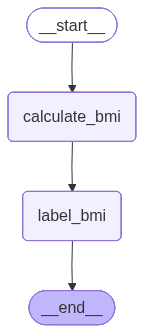

In [2]:
# for any wf, first we should define state
# TypeDict is a special type of dict where we can define type of data for keys

class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float
    category: str

# First we add our node functions and together we can create actual function
# in graph every node must take state as input and return state as output
def calculate_bmi(state: BMIState) -> BMIState:
    weight = state["weight_kg"]
    height = state["height_m"]
    bmi = weight / (height ** 2)

    # update and return state
    state["bmi"] = round(bmi, 2)
    return state

# this is 2nd node function
def label_bmi(state: BMIState) -> BMIState:
    bmi = state["bmi"]
    if bmi < 18.5:
        category = "Underweight"
    elif 18.5 <= bmi < 24.9:
        category = "Normal weight"
    elif 25 <= bmi < 29.9:
        category = "Overweight"
    else:
        category = "Obesity"

    state["category"] = category
    return state

# define graph
graph = StateGraph(BMIState)

# add nodes
graph.add_node("calculate_bmi",calculate_bmi)
graph.add_node("label_bmi", label_bmi)

# add edges
graph.add_edge(START, "calculate_bmi")
graph.add_edge("calculate_bmi", "label_bmi")
graph.add_edge("label_bmi", END)

# compile graph
workflow = graph.compile()

# visualize graph
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [3]:
# next step is to execute the graph, I/P is always a state
initial_state = {"weight_kg": 70, "height_m": 1.75}

# op is also always state
final_state = workflow.invoke({"weight_kg": 70, "height_m": 1.75})

print(final_state)

{'weight_kg': 70, 'height_m': 1.75, 'bmi': 22.86, 'category': 'Normal weight'}


### Workflow with LLM

This project builds a simple workflow using StateGraph to handle question-answering with a Large Language Model (LLM). It defines an LLMState to store questions and answers, creates a node that formulates prompts, queries the model, and updates the state with responses. The workflow demonstrates how to structure, execute, and visualize an LLM-based pipeline in a modular and reusable way.

In [4]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from dotenv import load_dotenv

load_dotenv(override=True)

True

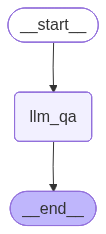

In [5]:
# initialize LLM
model = ChatOpenAI()

# create state
class LLMState(TypedDict):
    question: str
    answer: str

# create node function
def llm_qa(state: LLMState) -> LLMState:
    # extract question from state
    question = state['question']

    # form prompt
    prompt = f"Answer the following question concisely:\n{question}"

    # ask question from LLM
    answer = model.invoke(prompt).content

    # update answer in state
    state['answer'] = answer

    return state

# make graph
graph = StateGraph(LLMState)

# add nodes
graph.add_node("llm_qa",llm_qa)

# add edges
graph.add_edge(START, "llm_qa")
graph.add_edge("llm_qa", END)

# compile graph into workflow
workflow = graph.compile()

# visualize graph
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [6]:
# execute graph
initial_state = LLMState(question="how are you?")
final_state = workflow.invoke(initial_state)
print(final_state)

{'question': 'how are you?', 'answer': 'I am well, thank you.'}


### Prompt Chaining - Multiple LLMs

This project creates a workflow for automated blog generation using a state-driven graph. It defines a blogState to track the topic, outline, and final blog content. The workflow includes nodes for generating a structured outline and then expanding it into a complete blog post using a Large Language Model (LLM). This modular approach demonstrates how to automate content creation in a step-by-step, reusable pipeline.

In [7]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from dotenv import load_dotenv

load_dotenv()

True

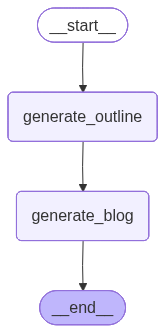

In [8]:
# Model
model = ChatOpenAI()

# State
class blogState(TypedDict):
    topic: str
    outline: str
    blog: str

# node1
def generate_outline(state: blogState) -> blogState:
    prompt = f"Write a detailed outline for a blog post about {state['topic']}"
    outline = model.invoke(prompt)
    state['outline'] = outline.content
    return state

# node 2
def generate_blog(state: blogState) -> blogState:
    prompt = f"Write a blog post based on the following topic:\n {state["topic"]} and outline:\n{state['outline']}"
    blog = model.invoke(prompt)
    state['blog'] = blog.content
    return state

graph = StateGraph(blogState)

# add node
graph.add_node("generate_outline",generate_outline)
graph.add_node("generate_blog",generate_blog)

# add edges
graph.add_edge(START, "generate_outline")
graph.add_edge("generate_outline", "generate_blog")
graph.add_edge("generate_blog", END)

# compile graph
workflow = graph.compile()

# visualize graph
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [9]:
initial_state = blogState(topic="The future of AI in healthcare")

final_state = workflow.invoke(initial_state)
print(final_state)

{'topic': 'The future of AI in healthcare', 'outline': 'I. Introduction\n    A. Brief overview of AI in healthcare\n    B. Importance of AI in revolutionizing healthcare industry\n\nII. Current applications of AI in healthcare\n    A. Diagnosis and treatment recommendations \n    B. Predictive analytics for patient outcomes \n    C. Robot-assisted surgery \n    D. Virtual health assistants \n\nIII. Advantages of AI in healthcare\n    A. Improved accuracy and efficiency in diagnosis \n    B. Personalized treatment plans based on individual patient data \n    C. Reduction in medical errors and complications \n    D. Cost savings for patients and healthcare providers \n\nIV. Challenges and limitations of AI in healthcare\n    A. Data privacy and security concerns \n    B. Lack of regulatory frameworks for AI algorithms \n    C. Bias in AI algorithms \n    D. Resistance from healthcare professionals \n\nV. The future of AI in healthcare\n    A. Integration of AI with electronic health reco

In [10]:
# Let's use Markdown and display to display better

from IPython.display import Markdown, display
display(Markdown(final_state["outline"]))

I. Introduction
    A. Brief overview of AI in healthcare
    B. Importance of AI in revolutionizing healthcare industry

II. Current applications of AI in healthcare
    A. Diagnosis and treatment recommendations 
    B. Predictive analytics for patient outcomes 
    C. Robot-assisted surgery 
    D. Virtual health assistants 

III. Advantages of AI in healthcare
    A. Improved accuracy and efficiency in diagnosis 
    B. Personalized treatment plans based on individual patient data 
    C. Reduction in medical errors and complications 
    D. Cost savings for patients and healthcare providers 

IV. Challenges and limitations of AI in healthcare
    A. Data privacy and security concerns 
    B. Lack of regulatory frameworks for AI algorithms 
    C. Bias in AI algorithms 
    D. Resistance from healthcare professionals 

V. The future of AI in healthcare
    A. Integration of AI with electronic health records 
    B. Expansion of AI in telemedicine and remote patient monitoring 
    C. Development of AI-powered medical devices 
    D. Collaboration between tech companies and healthcare providers 

VI. Ethical considerations of AI in healthcare
    A. Ensuring transparency and accountability in AI algorithms 
    B. Addressing concerns related to patient consent and data sharing 
    C. Mitigating biases and discrimination in AI algorithms 
    D. Maintaining patient trust in AI technologies 

VII. Conclusion
    A. Recap of key points discussed in the blog post 
    B. Emphasis on the potential of AI to transform healthcare delivery 
    C. Call to action for stakeholders to collaborate and address challenges in implementing AI in healthcare.

In [11]:
display(Markdown(final_state["blog"]))

AI, or artificial intelligence, has been making significant strides in various industries, with healthcare being one of the key areas of focus. The integration of AI in healthcare has the potential to revolutionize the way medical professionals diagnose, treat, and care for patients. In this blog post, we will explore the current applications, advantages, challenges, and limitations of AI in healthcare, as well as the future implications and ethical considerations of this technology.

AI in healthcare is already being used for a wide range of applications, including diagnosis and treatment recommendations, predictive analytics for patient outcomes, robot-assisted surgery, and virtual health assistants. These applications have led to improved accuracy and efficiency in diagnosis, personalized treatment plans based on individual patient data, and a reduction in medical errors and complications. In addition, AI in healthcare has resulted in cost savings for both patients and healthcare providers.

However, the implementation of AI in healthcare also comes with challenges and limitations. Data privacy and security concerns, lack of regulatory frameworks for AI algorithms, bias in AI algorithms, and resistance from healthcare professionals are some of the key challenges that need to be addressed. Despite these challenges, the future of AI in healthcare looks promising.

Moving forward, the integration of AI with electronic health records, expansion of AI in telemedicine and remote patient monitoring, development of AI-powered medical devices, and collaboration between tech companies and healthcare providers are some of the potential areas for growth in AI in healthcare. It is essential for stakeholders to collaborate and address challenges in implementing AI in healthcare to realize the full potential of this technology.

Ethical considerations also play a crucial role in the adoption of AI in healthcare. Ensuring transparency and accountability in AI algorithms, addressing concerns related to patient consent and data sharing, mitigating biases and discrimination in AI algorithms, and maintaining patient trust in AI technologies are some of the key ethical issues that need to be addressed.

In conclusion, the future of AI in healthcare holds immense potential to transform the way healthcare is delivered. By addressing the challenges and limitations of AI implementation in healthcare and prioritizing ethical considerations, stakeholders can work together to harness the power of AI to improve patient outcomes and revolutionize the healthcare industry. It is imperative for all stakeholders to collaborate and take action to ensure the successful integration of AI in healthcare for the benefit of patients and healthcare providers alike.